[View in Colaboratory](https://colab.research.google.com/github/nikolay-bushkov/kaist_internship/blob/master/active_learning_for_question_classification.ipynb)

# Predicting question type on the Yahoo dataset

Based on https://developers.google.com/machine-learning/guides/text-classification/ and https://doi.org/10.1145/3159652.3159733 (https://www.researchgate.net/publication/322488294_Identifying_Informational_vs_Conversational_Questions_on_Community_Question_Answering_Archives)

In [0]:
!pip3 install -q modAL

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

## Data preparation

In [0]:
!wget -q http://files.deeppavlov.ai/datasets/yahoo_answers_data/train.csv

In [0]:
!wget -q http://files.deeppavlov.ai/datasets/yahoo_answers_data/valid.csv

In [0]:
train_ds = pd.read_csv('train.csv')

In [0]:
test_ds = pd.read_csv('valid.csv')

In [0]:
X_train_full, y_train_full = train_ds['Title'].values.astype(np.unicode).reshape(-1, 1), train_ds['Label'].values

In [0]:
X_test, y_test = test_ds['Title'].values.astype(np.unicode).reshape(-1, 1), test_ds['Label'].values

In [0]:
for text, target in zip(X_train_full[2:4], y_train_full[2:4]):
    print("Target: {}".format(target))
    print(text)

Target: 1
['Ladies, what strain or type of bud do you like to smoke the most?']
Target: 0
['How long does it take for an nds rom to upload onto the internet?']


## Baseline model

In [0]:
def modAL_workaround(X):
    """Picklable function"""
    return X.reshape(-1)

In [0]:
class FCClassifierROCAUC(MLPClassifier):
    """Just replace accuracy with ROC-AUC"""
    def score(self, X, y, sample_weight=None):
        from sklearn.metrics import roc_auc_score
        return roc_auc_score(y, self.predict(X), average='macro', sample_weight=sample_weight)

In [0]:
steps = [
    ('modAL_workaround', FunctionTransformer(func=modAL_workaround)),
    ('featurizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 3))),
    ('feature_selector', SelectKBest(f_classif, k=1000)),
    ('classifier', FCClassifierROCAUC(hidden_layer_sizes=(32, 32),
                          alpha=0.01,
                          # unfortunately, sklearn implementation doesn't allow to dropout neurons, so set this
                          batch_size=4,
                          max_iter=1000,
                          early_stopping=True))
]

In [0]:
pipe = Pipeline(steps)

In [0]:
%time pipe.fit(X_train_full, y_train_full)

CPU times: user 7.84 s, sys: 3.64 s, total: 11.5 s
Wall time: 6.58 s


Pipeline(memory=None,
     steps=[('modAL_workaround', FunctionTransformer(accept_sparse=False,
          func=<function modAL_workaround at 0x7f0813370ea0>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=True)), ('featurizer', TfidfVectorizer(analyzer='word', binary=False...ue, solver='adam', tol=0.0001, validation_fraction=0.1,
          verbose=False, warm_start=False))])

In [0]:
pipe.score(X_train_full, y_train_full)

0.8529807876665791

In [0]:
pipe.score(X_test, y_test)

0.7090358140462889

## Active learning part

In [0]:
from modAL.models import ActiveLearner

In [0]:
def random_sampling(classifier, X_pool, n_instances=1, **uncertainty_measure_kwargs):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples), size=n_instances)
    return query_idx, X_pool[query_idx]

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
SEED_SIZE = 128
QUERY_SIZE = 4
QUERY_STEPS = (len(X_train_full) - SEED_SIZE) // QUERY_SIZE

In [0]:
X_seed, X_pool, y_seed, y_pool = train_test_split(X_train_full, y_train_full, train_size=SEED_SIZE, random_state=42, stratify=y_train_full)

/home/nab/PycharmProjects/work/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [0]:
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling

In [0]:
from tqdm import tqdm

In [0]:
queries = range(1, QUERY_STEPS + 1)

### Random sampling and uncertainty sampling

In [0]:
X_pool_rs, X_pool_us, y_pool_rs, y_pool_us = X_pool[:], X_pool[:], y_pool[:], y_pool[:]

In [0]:
rs_scores = list()
us_scores = list()

In [0]:
rs_learner = ActiveLearner(
    estimator=Pipeline(steps),
    query_strategy=random_sampling,
    X_training=X_seed, y_training=y_seed
)
us_learner = ActiveLearner(
    estimator=Pipeline(steps),
    query_strategy=uncertainty_sampling,
    X_training=X_seed, y_training=y_seed
)

In [0]:
for query_step in tqdm(queries):
    
    #random
    query_idx_rs, query_inst_rs = rs_learner.query(X_pool_rs, n_instances=QUERY_SIZE)
    rs_learner.teach(query_inst_rs, y_pool_rs[query_idx_rs])
    X_pool_rs, y_pool_rs = np.delete(X_pool_rs, query_idx_rs, axis=0), np.delete(y_pool_rs, query_idx_rs)
    rs_scores.append(rs_learner.score(X_test, y_test))
    
    #uncertainty
    query_idx_us, query_inst_us = us_learner.query(X_pool_us, n_instances=QUERY_SIZE)
    us_learner.teach(query_inst_us, y_pool_us[query_idx_us])
    X_pool_us, y_pool_us = np.delete(X_pool_us, query_idx_us, axis=0), np.delete(y_pool_us, query_idx_us)
    us_scores.append(us_learner.score(X_test, y_test))

100%|██████████| 871/871 [1:16:31<00:00,  5.27s/it]


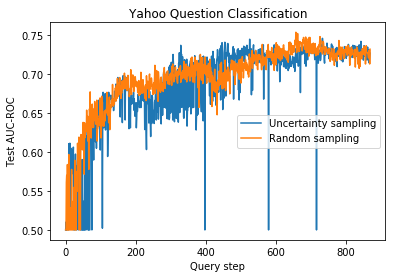

In [0]:
plt.plot(us_scores, label='Uncertainty sampling')
plt.plot(rs_scores, label='Random sampling')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()

### Entropy sampling and margin sampling

In [0]:
X_pool_es, X_pool_ms, y_pool_es, y_pool_ms = X_pool[:], X_pool[:], y_pool[:], y_pool[:]

In [0]:
es_scores = list()
ms_scores = list()

In [0]:
es_learner = ActiveLearner(
    estimator=Pipeline(steps),
    query_strategy=entropy_sampling,
    X_training=X_seed, y_training=y_seed
)
ms_learner = ActiveLearner(
    estimator=Pipeline(steps),
    query_strategy=margin_sampling,
    X_training=X_seed, y_training=y_seed
)

In [0]:
for query_step in tqdm(queries):
    
    #entropy
    query_idx_es, query_inst_es = es_learner.query(X_pool_es, n_instances=QUERY_SIZE)
    es_learner.teach(query_inst_es, y_pool_es[query_idx_es])
    X_pool_es, y_pool_es = np.delete(X_pool_es, query_idx_es, axis=0), np.delete(y_pool_es, query_idx_es)
    es_scores.append(es_learner.score(X_test, y_test))
    
    #margin
    query_idx_ms, query_inst_ms = ms_learner.query(X_pool_ms, n_instances=QUERY_SIZE)
    ms_learner.teach(query_inst_ms, y_pool_ms[query_idx_ms])
    X_pool_ms, y_pool_ms = np.delete(X_pool_ms, query_idx_ms, axis=0), np.delete(y_pool_ms, query_idx_ms)
    ms_scores.append(ms_learner.score(X_test, y_test))

100%|██████████| 871/871 [1:22:58<00:00,  5.72s/it]


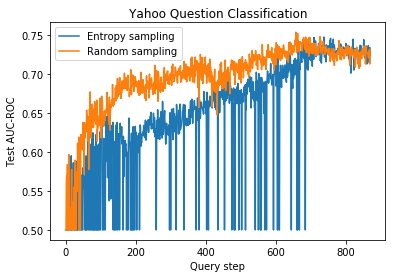

In [0]:
plt.plot(es_scores, label='Entropy sampling')
plt.plot(rs_scores, label='Random sampling')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()

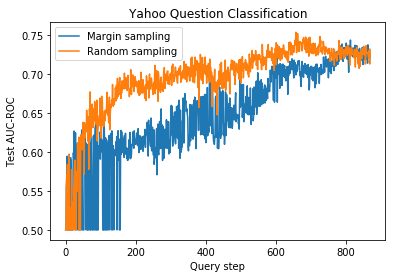

In [0]:
plt.plot(ms_scores, label='Margin sampling')
plt.plot(rs_scores, label='Random sampling')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()

## Summary

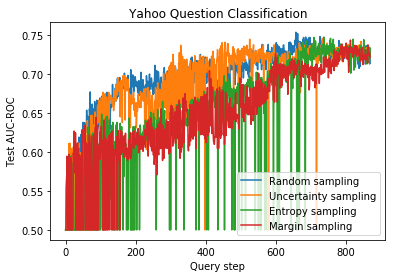

In [0]:
plt.plot(rs_scores, label='Random sampling')
plt.plot(us_scores, label='Uncertainty sampling')
plt.plot(es_scores, label='Entropy sampling')
plt.plot(ms_scores, label='Margin sampling')
plt.title('Yahoo Question Classification')
plt.xlabel('Query step')
plt.ylabel('Test AUC-ROC')
plt.legend()